In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import xlsxwriter
from PIL import Image
import os
from PIL.ExifTags import TAGS
import piexif
import random
from os import listdir
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
#read in excel files
xls18 = pd.ExcelFile('NHL 2017-18.xls')
season18 = pd.read_excel(xls18, 'TOT',header=2)
#xls17 = pd.ExcelFile('NHL 2016-17.xls')
#season17 = pd.read_excel(xls17, 'All Sits',header=2)
#shots=pd.read_csv("shots_2017.csv")

In [3]:
season18=season18[season18.columns[~season18.columns.isin(["TOI.1","TOI.2","TOI.3","iCF.1","iCF.2","iFF.1","iHF.1","iPENT2",
                                                  "iPENT5","iPEND2","iPEND5",'CF.1','CA.1','FF.1','FA.1','SF.1','SA.1'
                                                  ,'GF.1','GA.1','GP.1', 'G.1', 'A.1', 'PTS.1', '+/-.1','PIM.1',
                                                  'TOI.4', 'OPS.1', 'DPS.1', 'PS.1','A1'])]]

In [4]:
season18=season18[season18['Cap Hit']>1000000]
season18=season18.reset_index(drop=True)

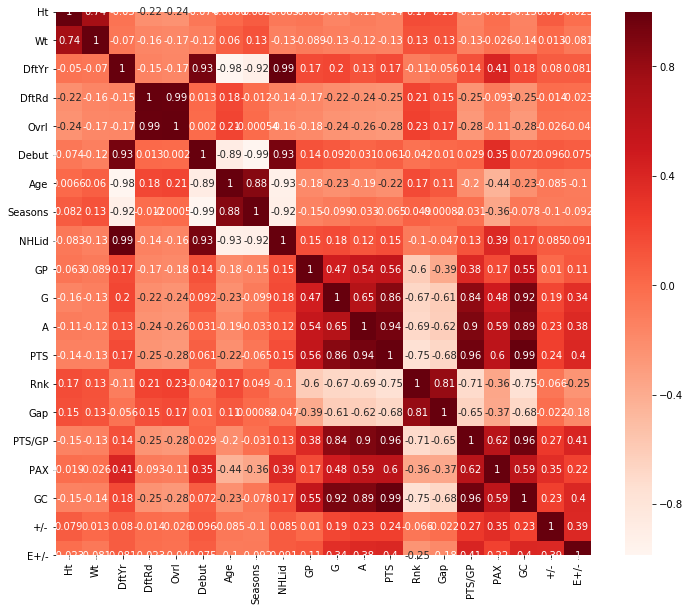

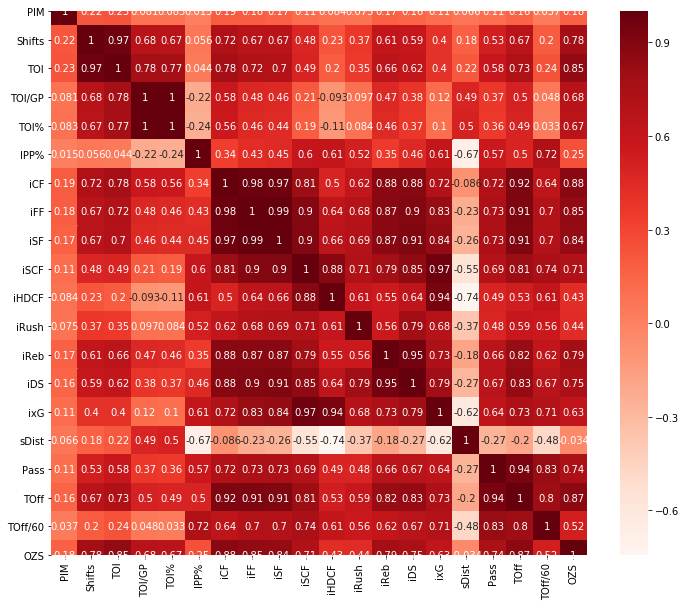

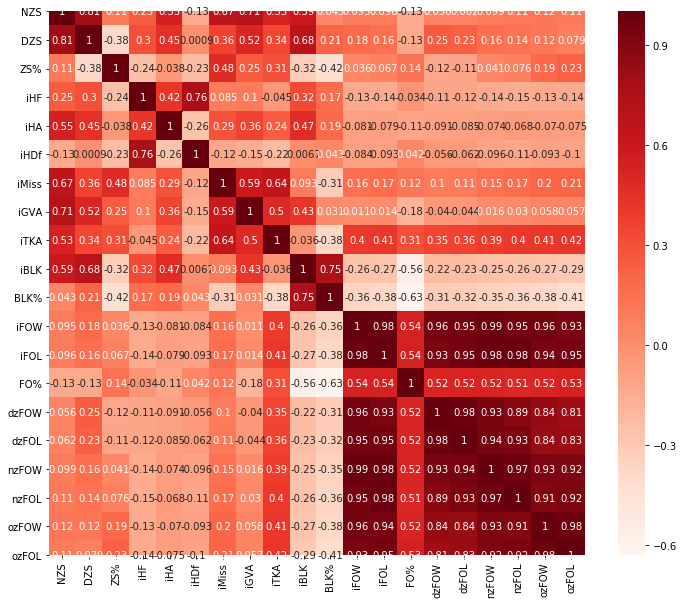

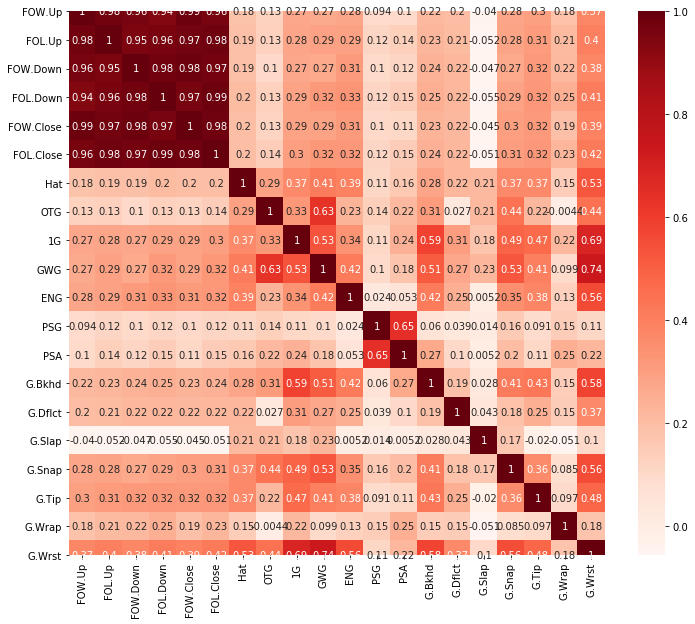

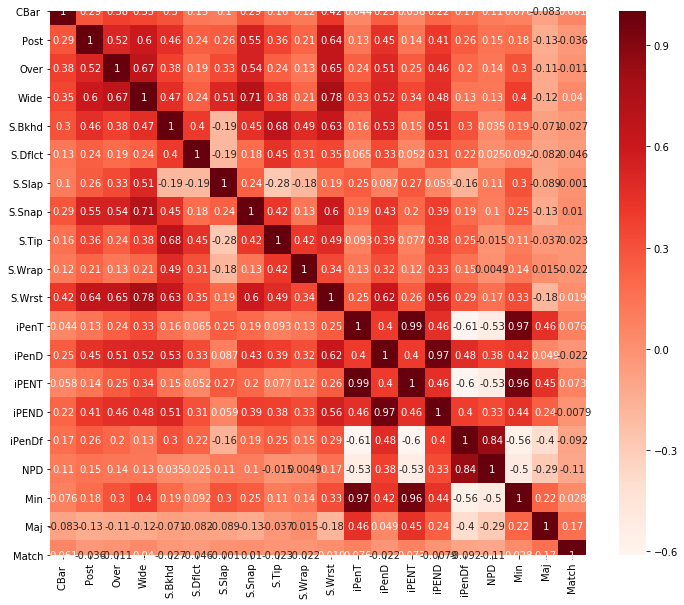

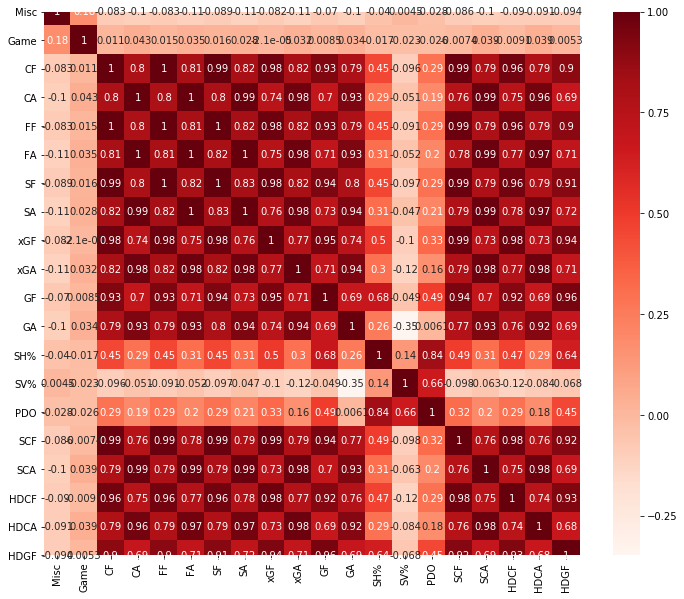

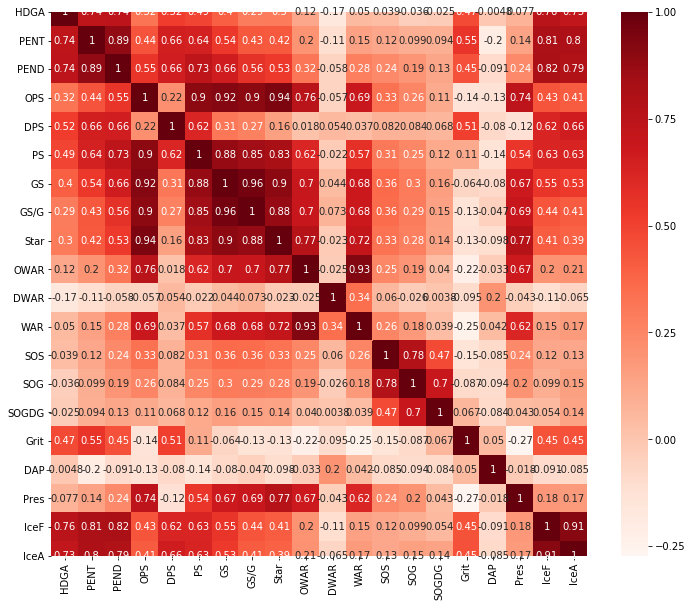

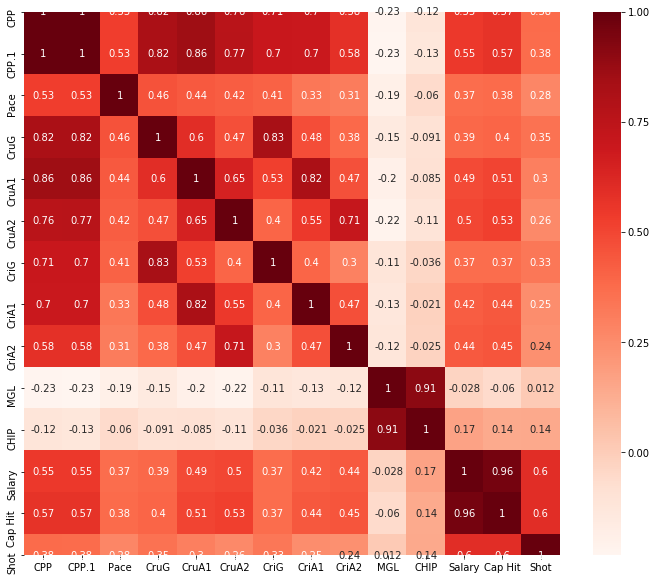

In [5]:
corr = season18.corr()
for i in range(0,int(season18.shape[1]/20)):
    plt.figure(figsize=(12,10))
    sns.heatmap(corr.loc[corr.columns[i*20:i*20+20],corr.columns[i*20:i*20+20]], annot=True, cmap=plt.cm.Reds)
    plt.show()

In [6]:
modelSeason18=season18.copy()
modelSeason18.reset_index(drop=True,inplace=True)

In [7]:
names=modelSeason18['CorsicaID']

In [8]:
modelSeason18.drop(modelSeason18.columns[modelSeason18.dtypes=='object'], axis=1, inplace=True)
modelSeason18.drop(['Born'], axis=1, inplace=True)

In [9]:
modelSeason18.shape

(395, 154)

In [10]:
modelSeason18.fillna('?',inplace=True)

In [11]:
for col in modelSeason18.columns:
    if modelSeason18[col].dtype == object:
        count = 0
        count = [count + 1 for x in modelSeason18[col] if x == '?']
        print(col + ' ' + str(sum(count)))

DftYr 36
DftRd 36
Ovrl 36
SOS 228
SOG 228
SOGDG 228
MGL 131
CHIP 131


In [12]:
modelSeason18.drop(['SOS','SOG','SOGDG','MGL','CHIP','Salary'], axis=1, inplace=True)

In [13]:
for column in modelSeason18.columns:
    modelSeason18.loc[modelSeason18[column] == '?', column] = np.nan
modelSeason18.dropna(axis = 0, inplace = True)
modelSeason18X=modelSeason18.drop(['Cap Hit','NHLid'], axis=1)
modelSeason18Y=modelSeason18[['Cap Hit']]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


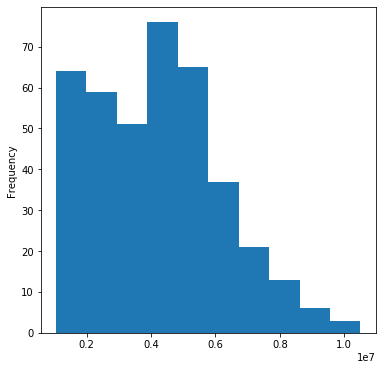

In [14]:
fig = plt.figure(figsize=(6,6)) # define plot area
ax = fig.gca()
season18['Cap Hit'].plot.hist(ax = ax, bins = 10)

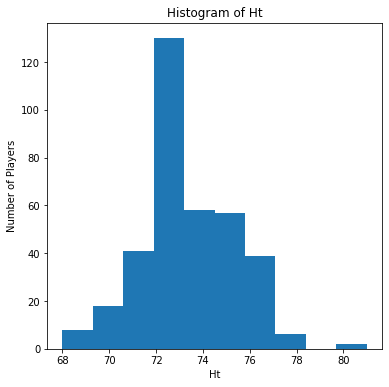

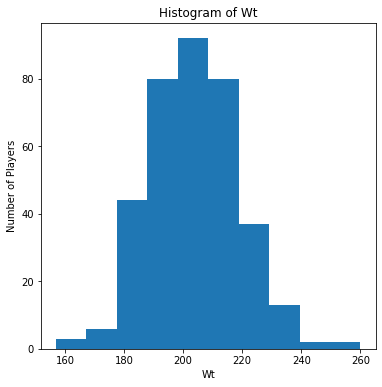

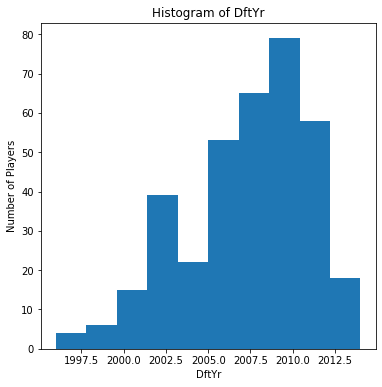

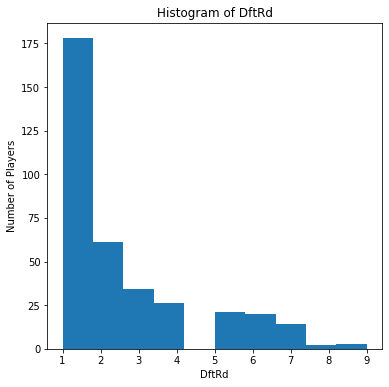

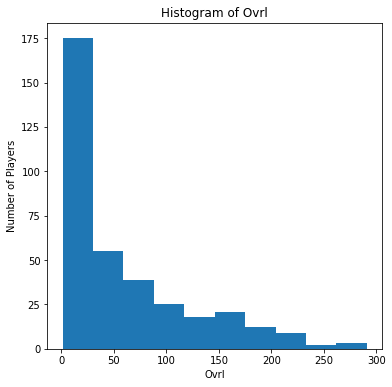

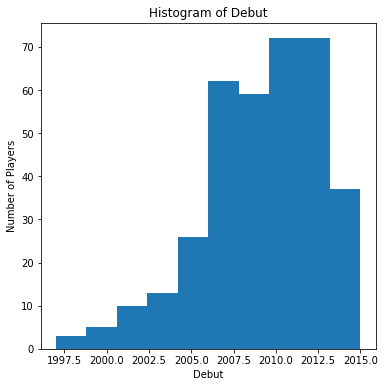

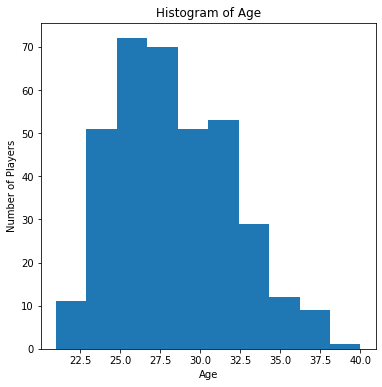

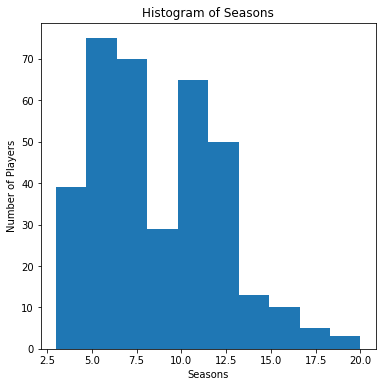

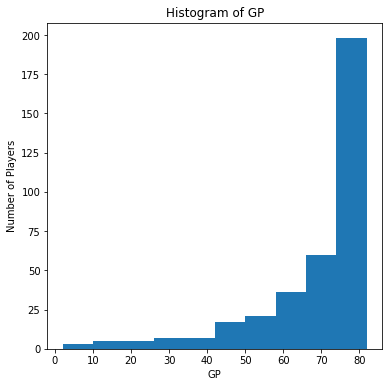

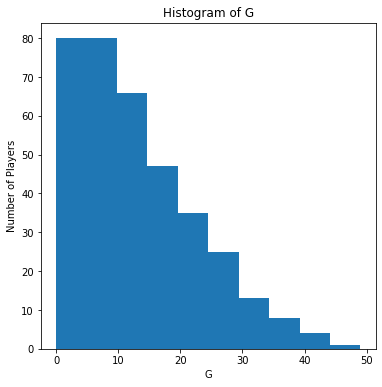

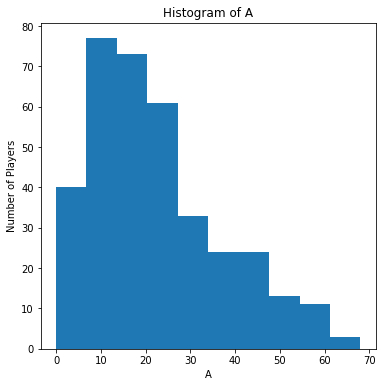

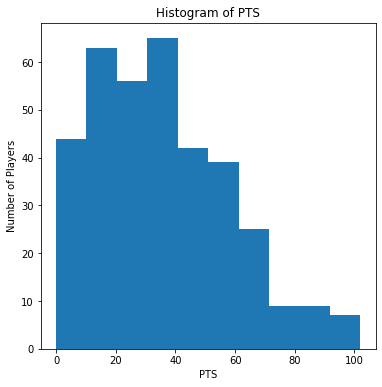

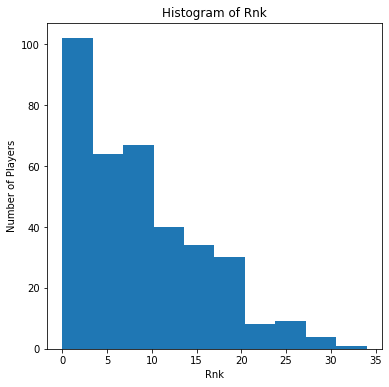

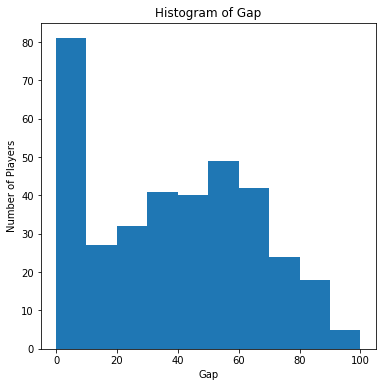

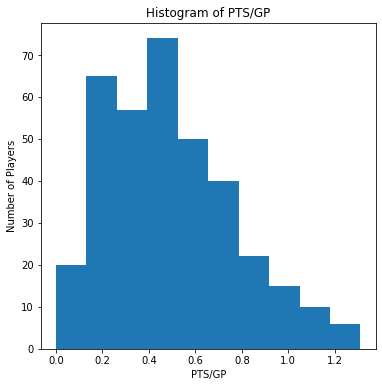

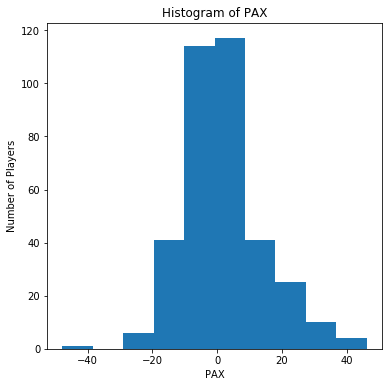

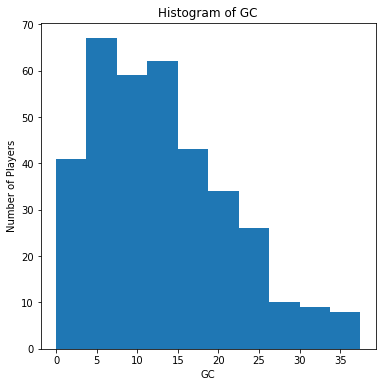

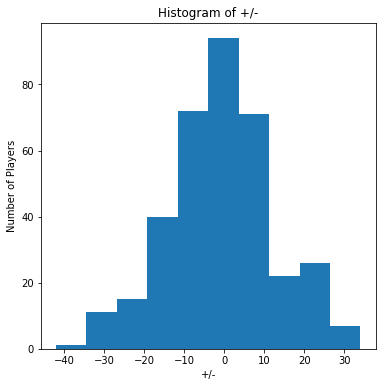

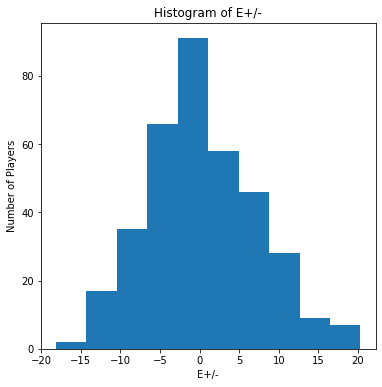

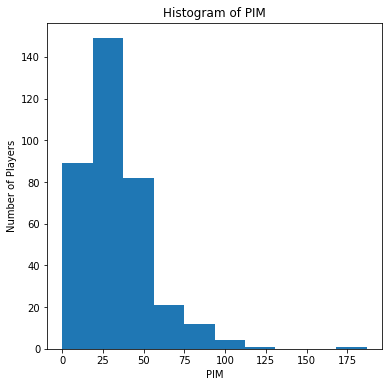

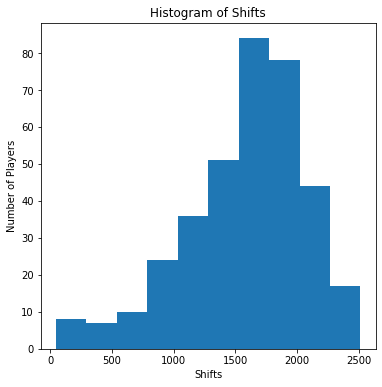

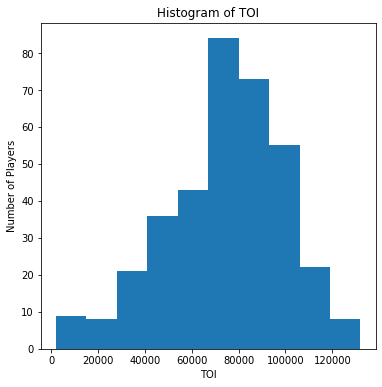

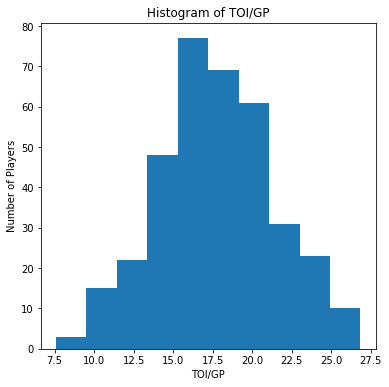

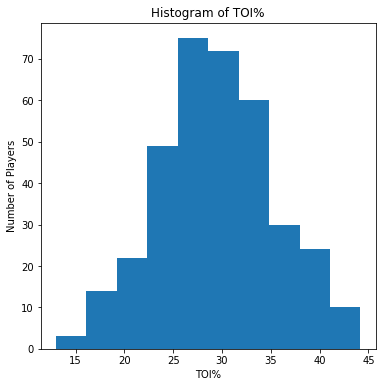

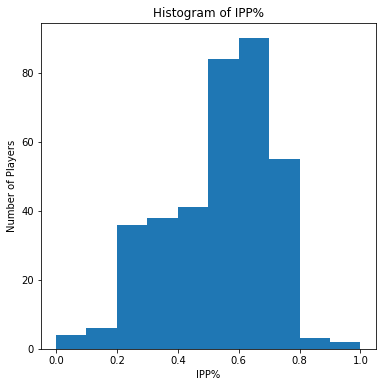

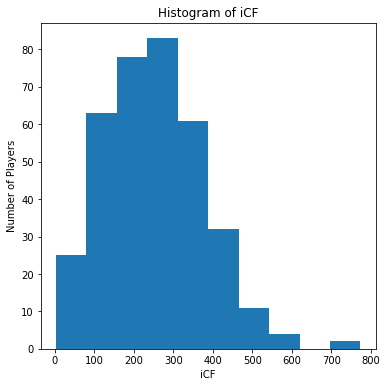

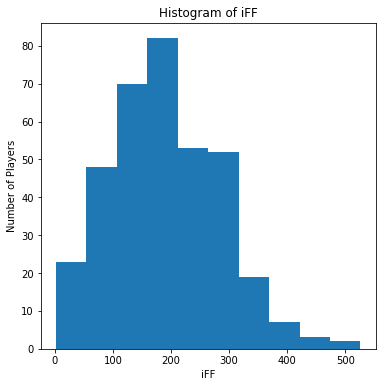

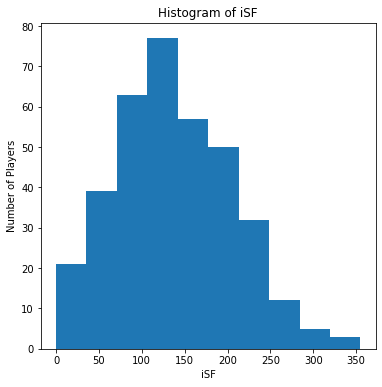

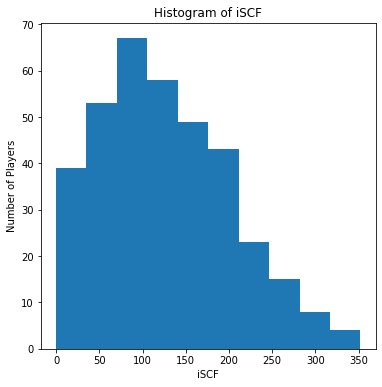

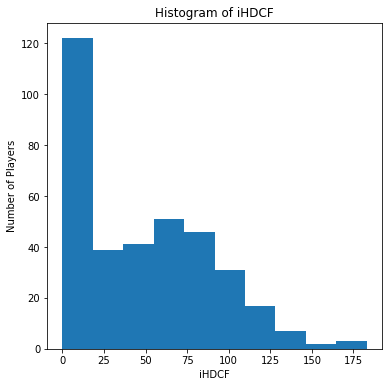

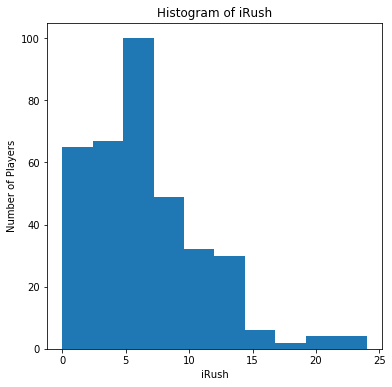

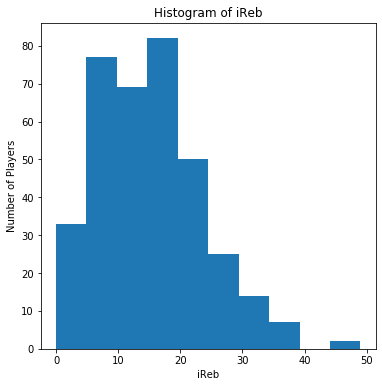

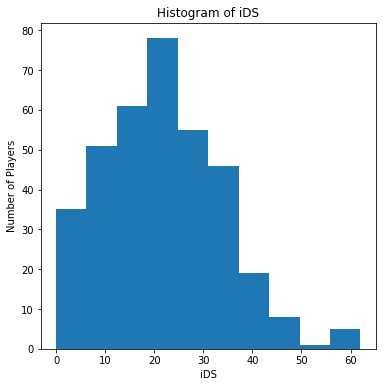

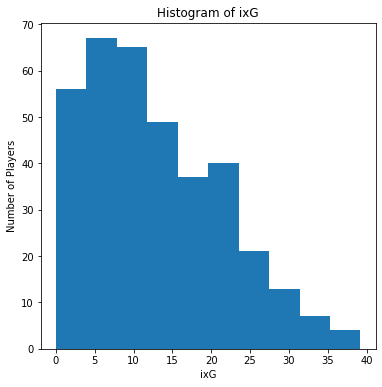

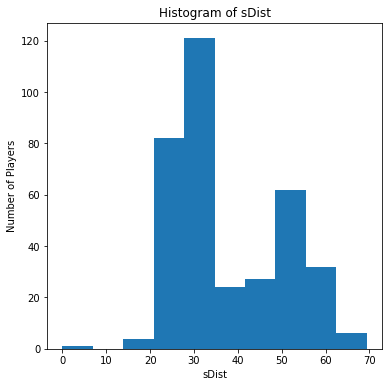

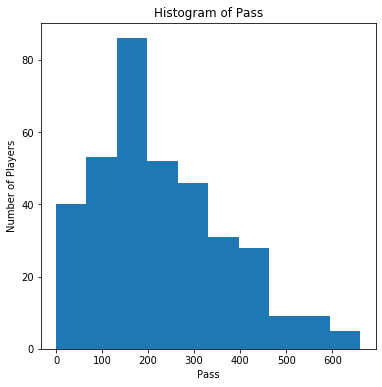

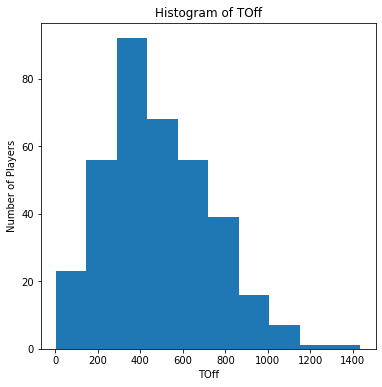

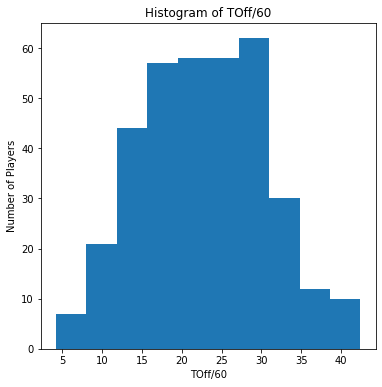

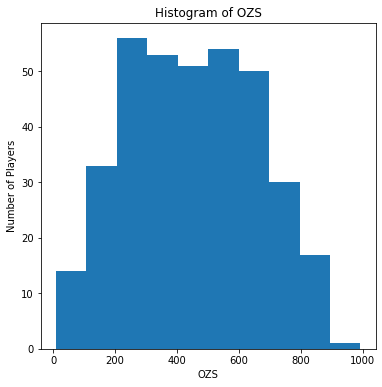

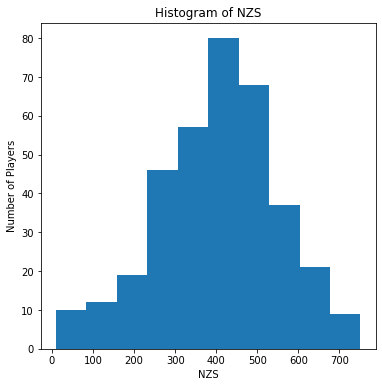

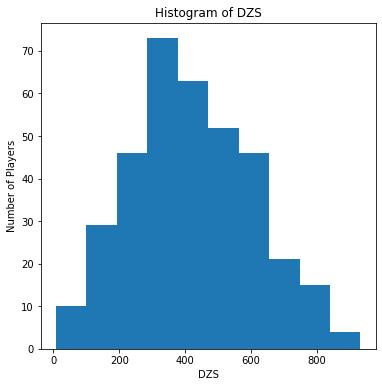

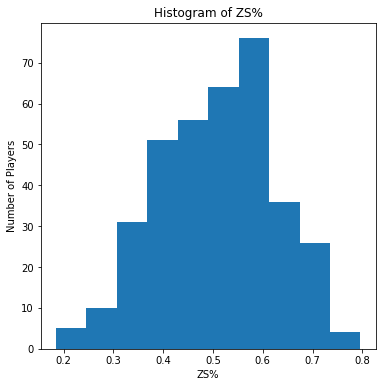

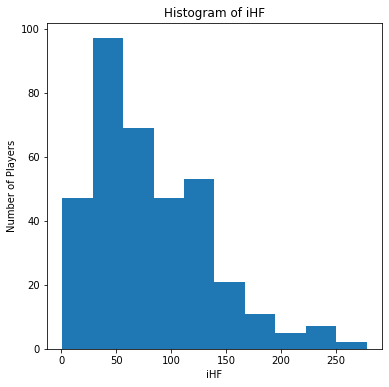

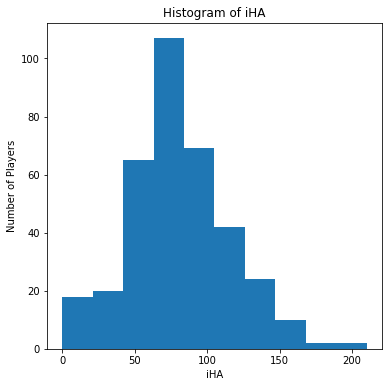

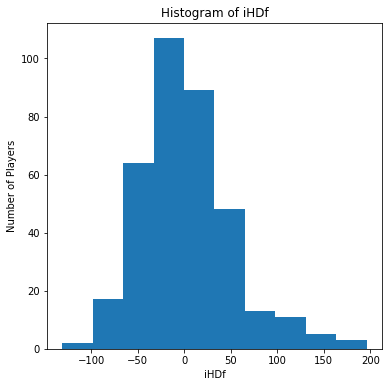

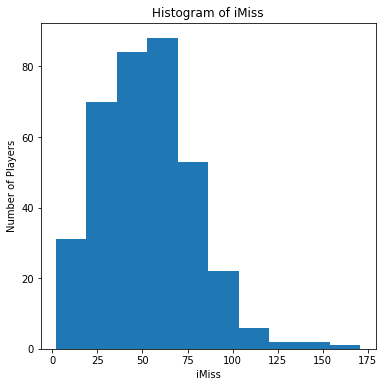

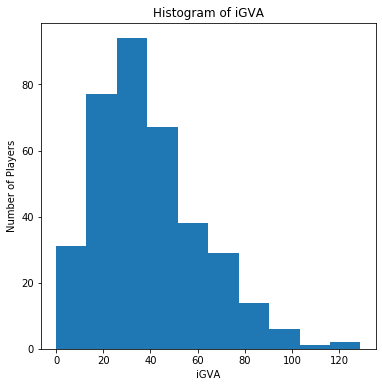

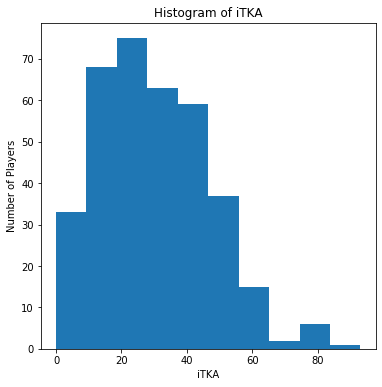

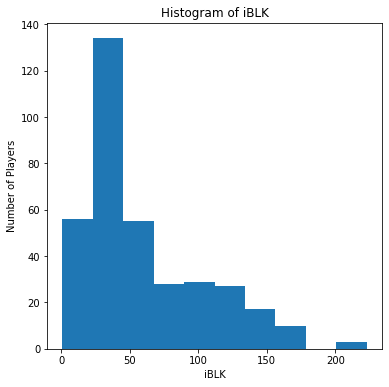

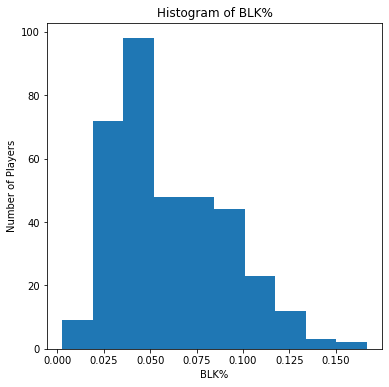

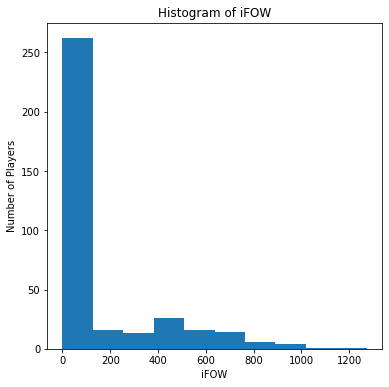

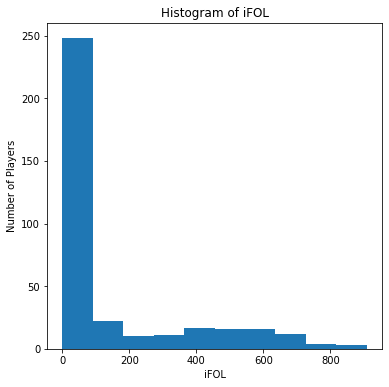

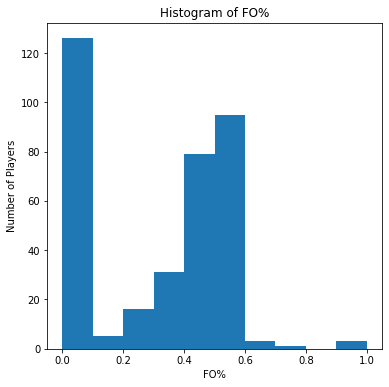

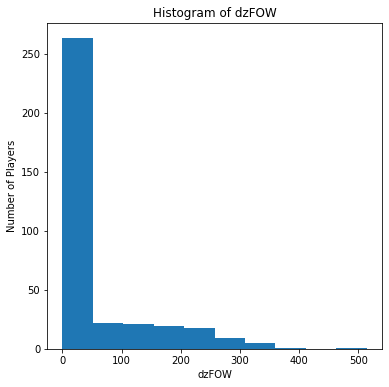

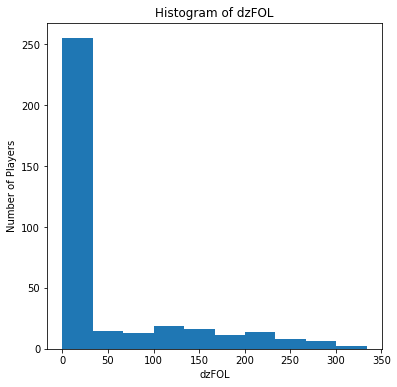

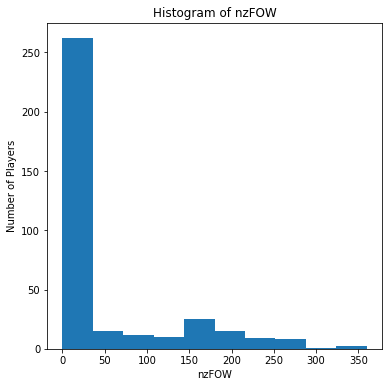

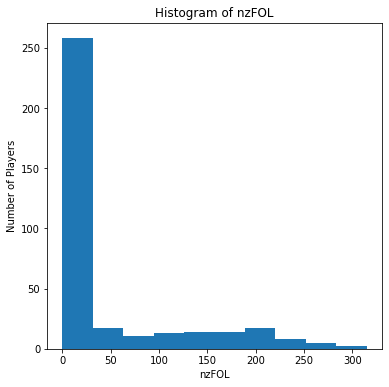

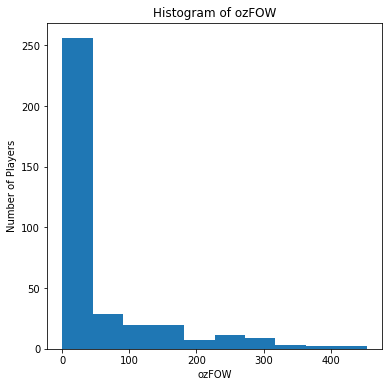

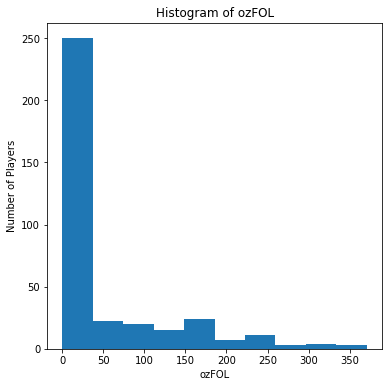

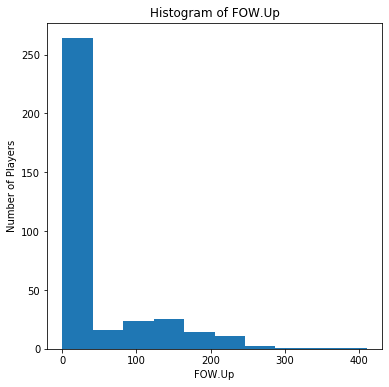

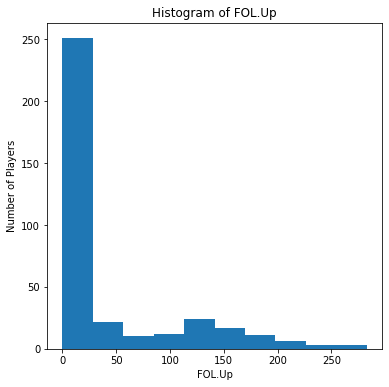

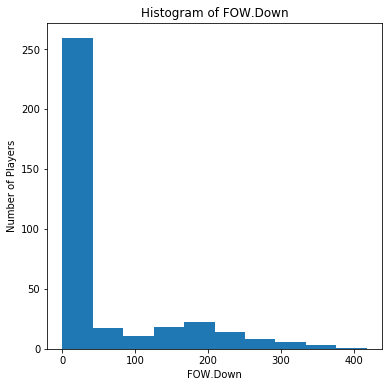

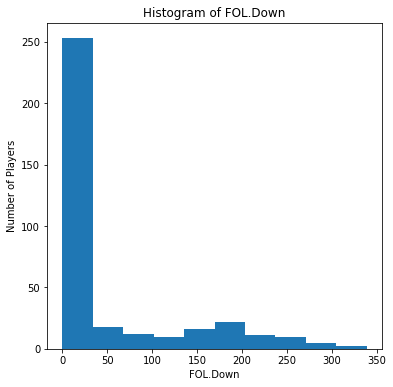

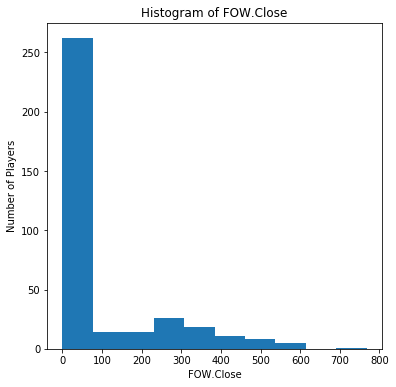

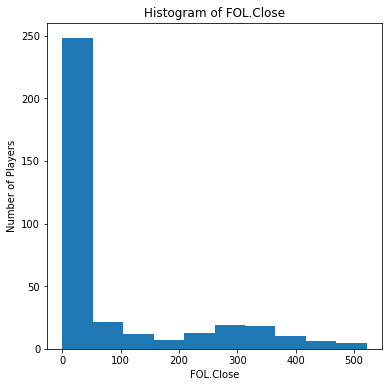

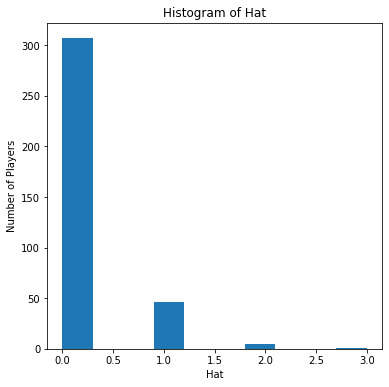

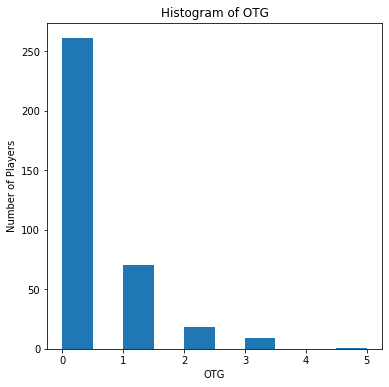

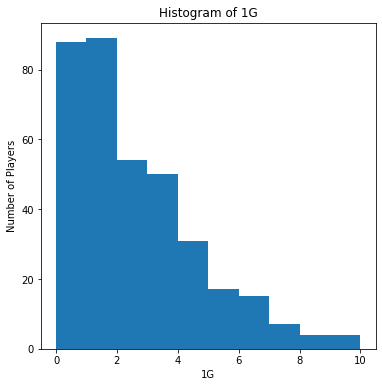

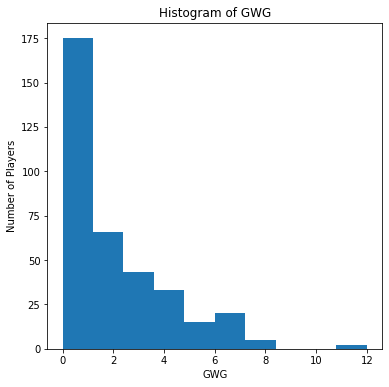

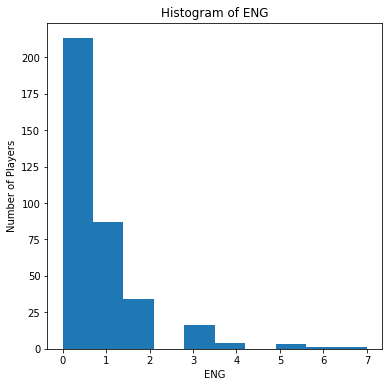

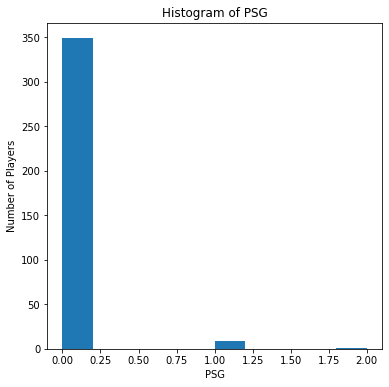

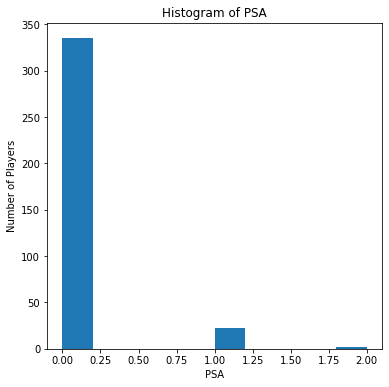

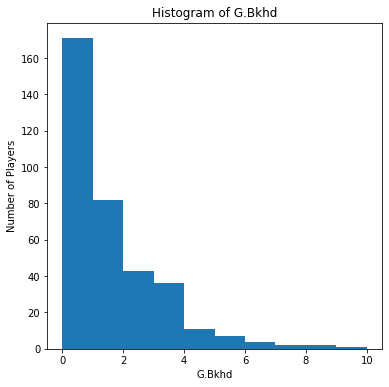

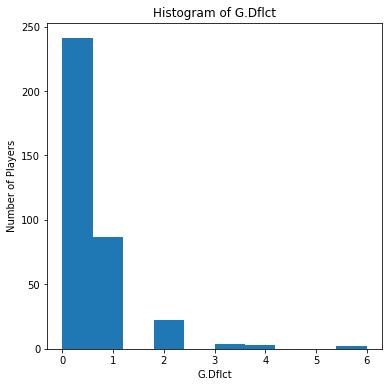

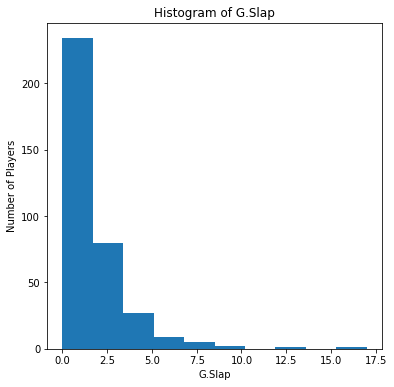

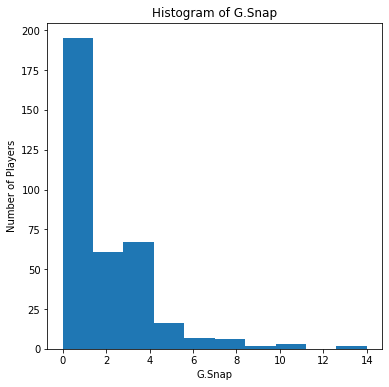

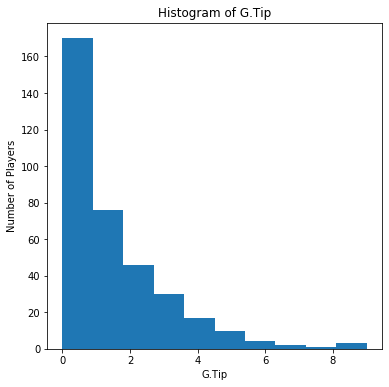

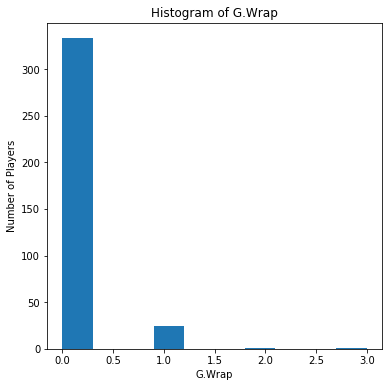

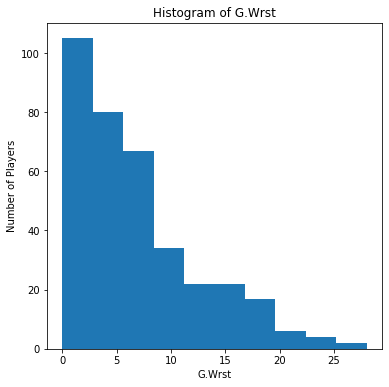

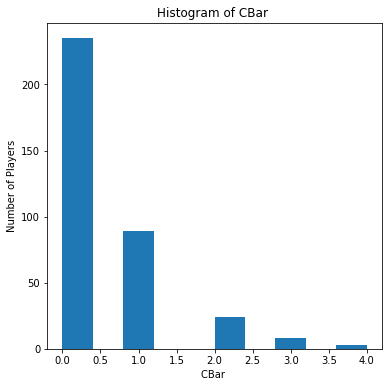

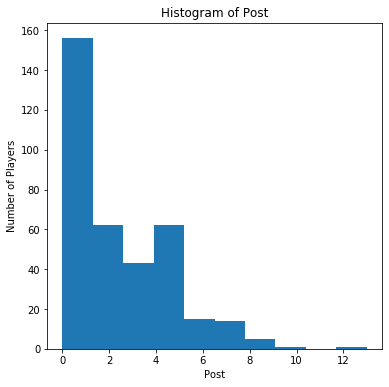

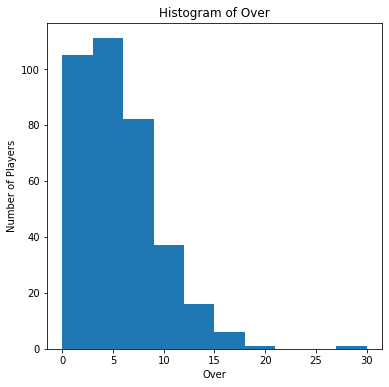

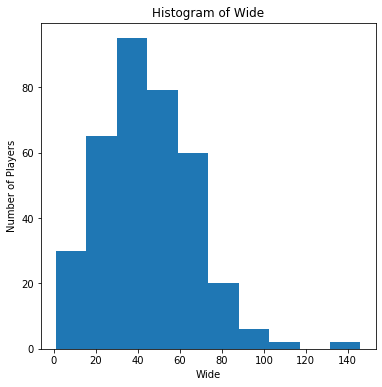

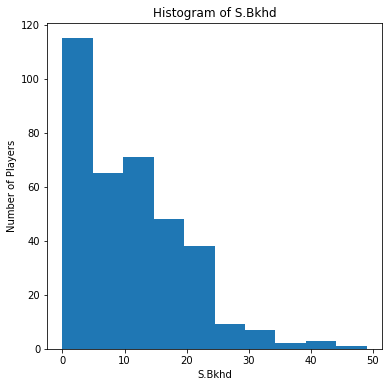

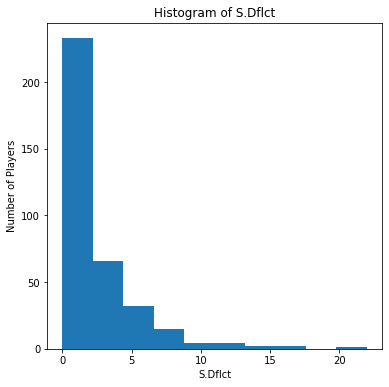

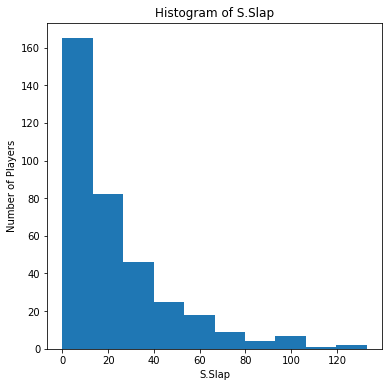

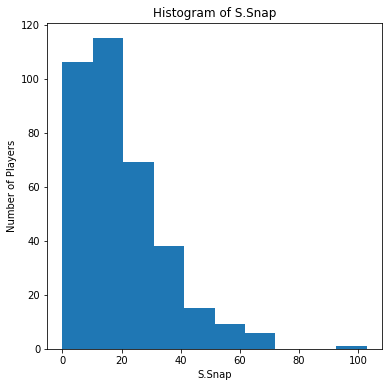

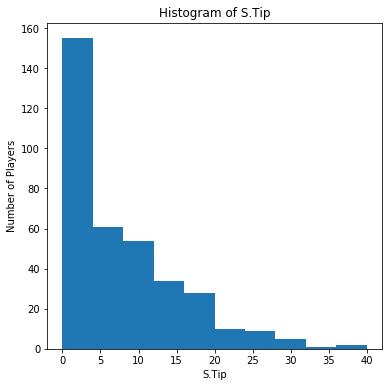

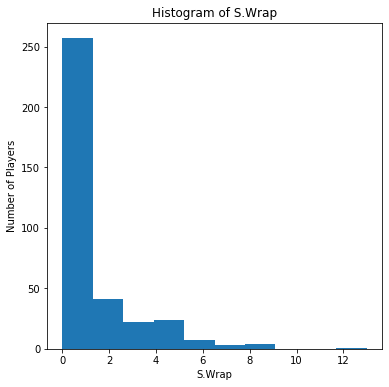

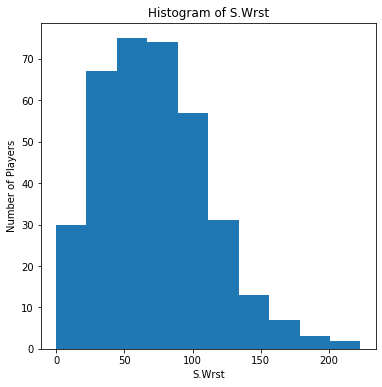

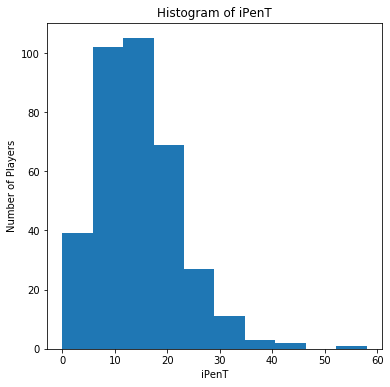

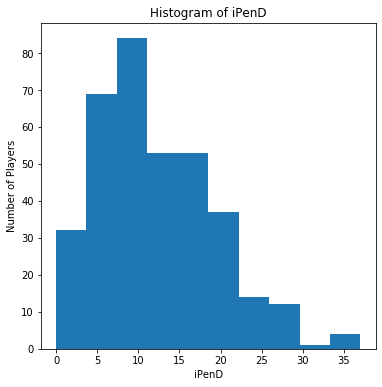

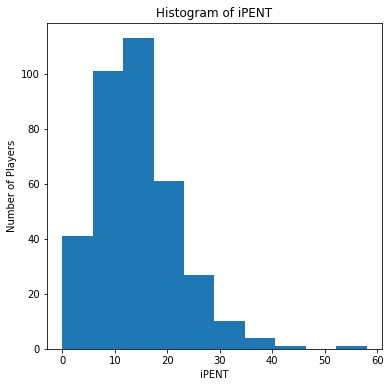

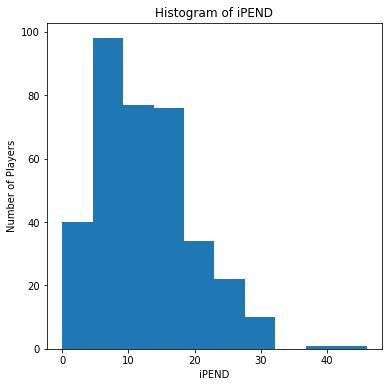

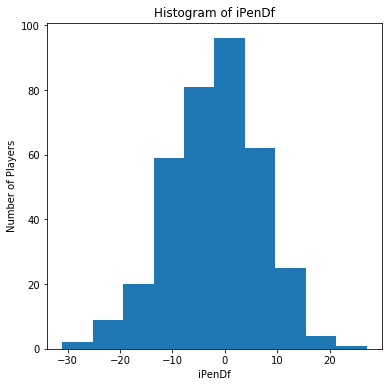

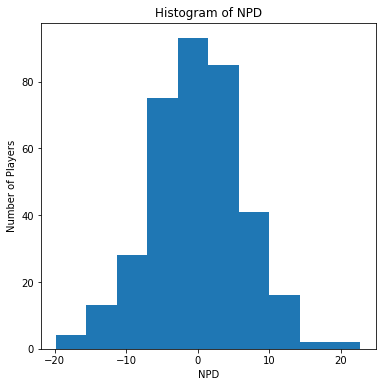

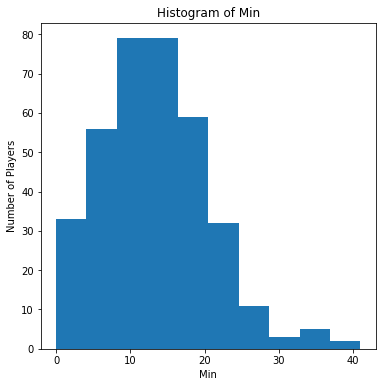

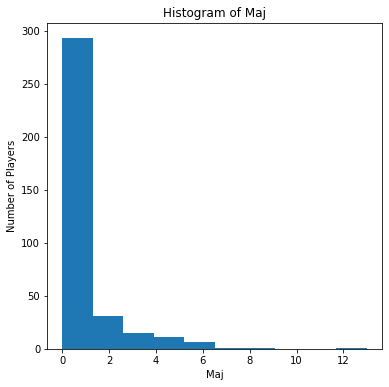

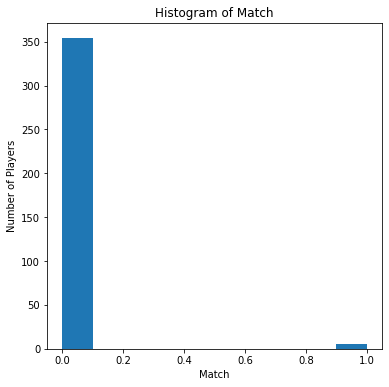

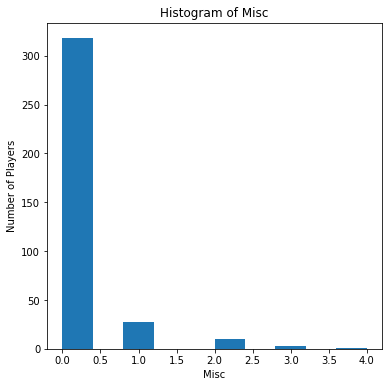

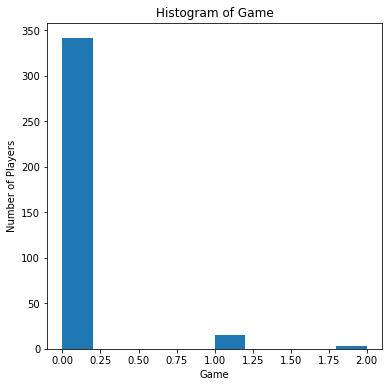

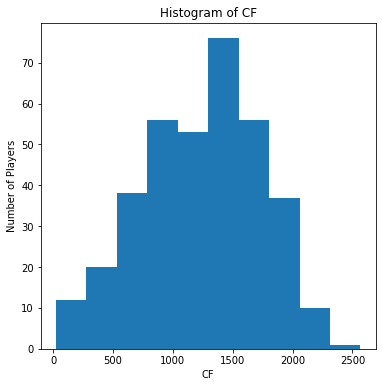

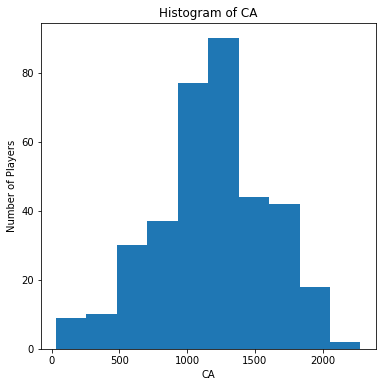

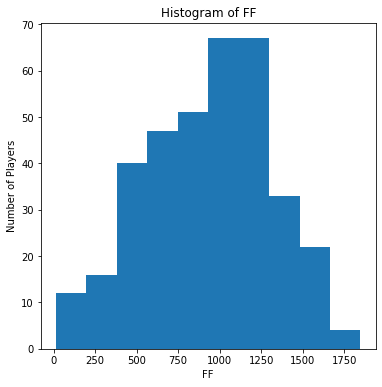

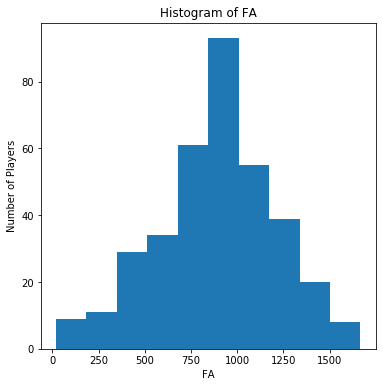

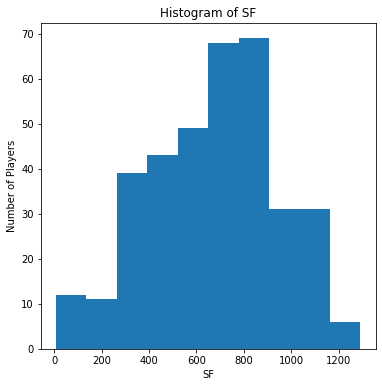

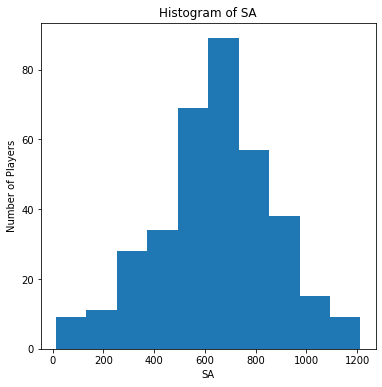

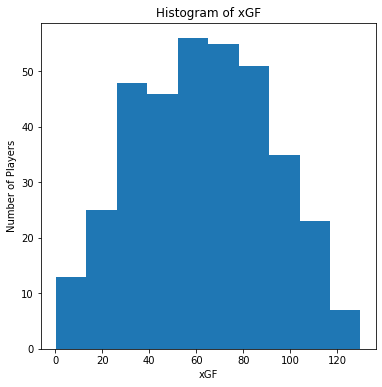

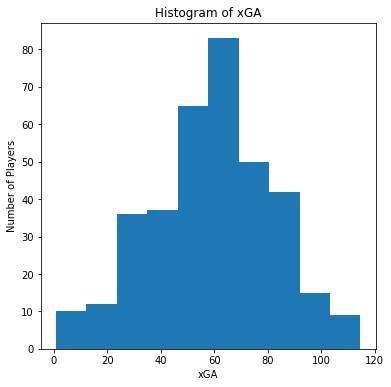

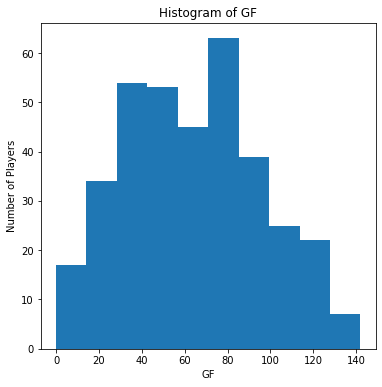

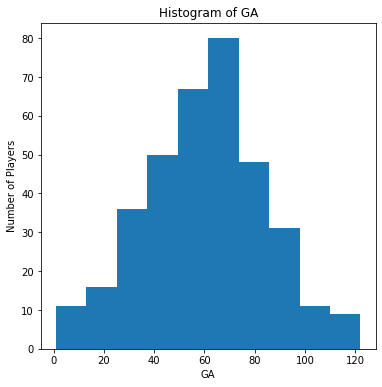

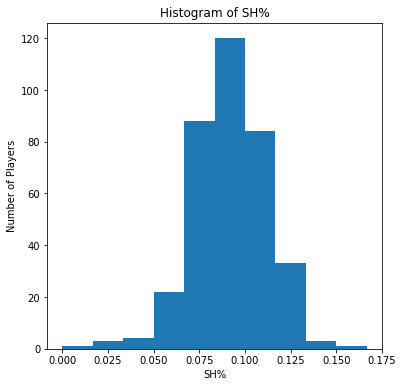

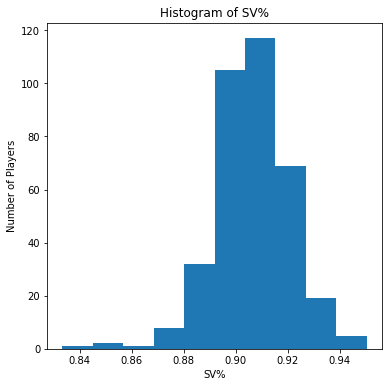

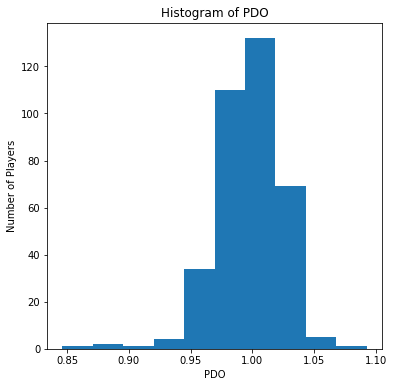

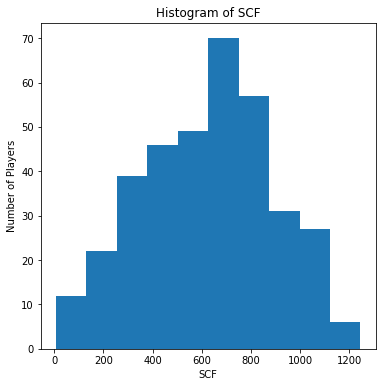

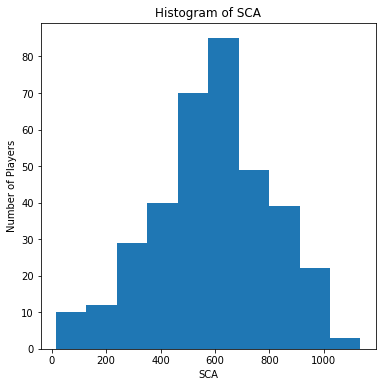

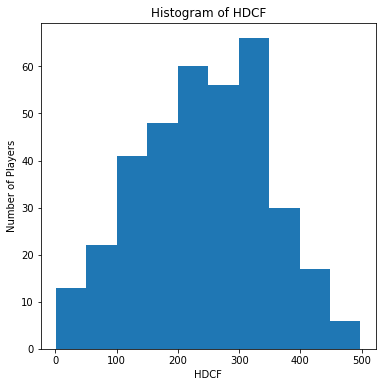

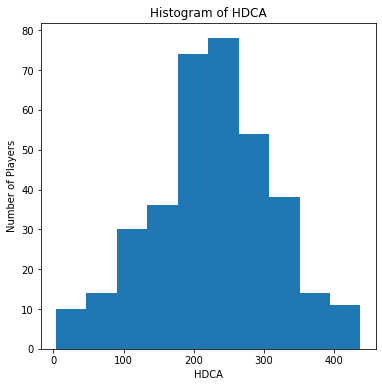

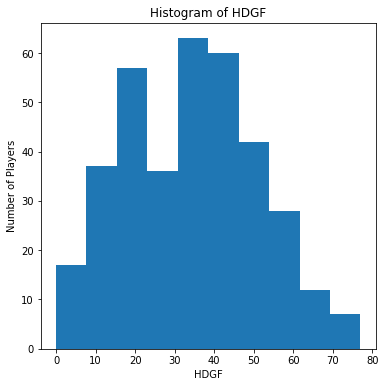

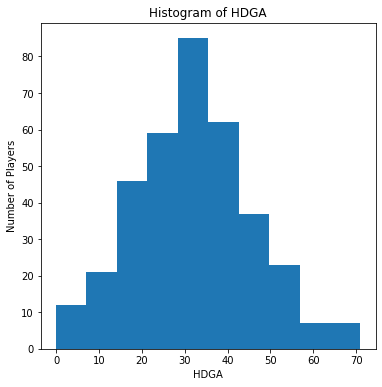

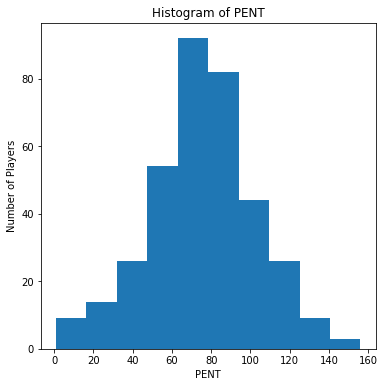

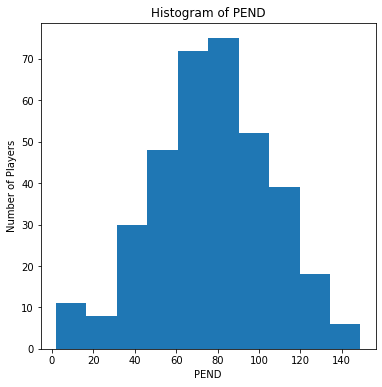

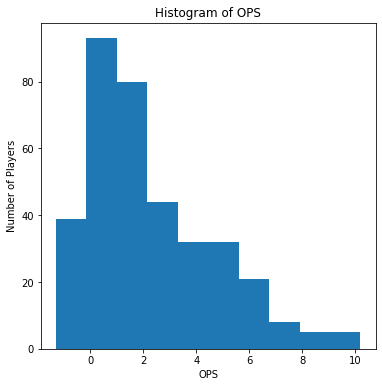

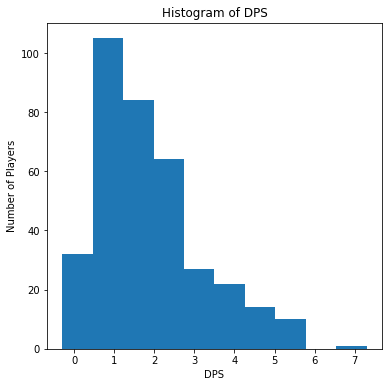

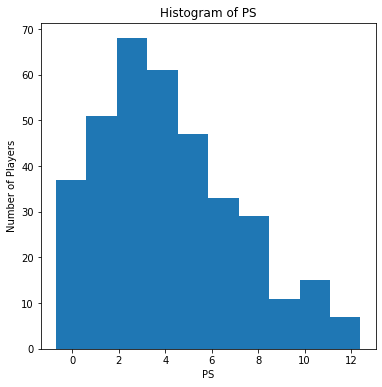

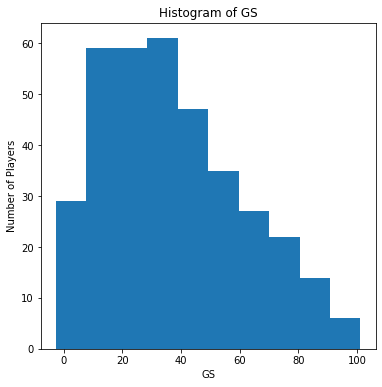

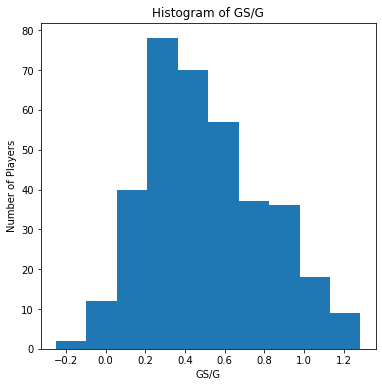

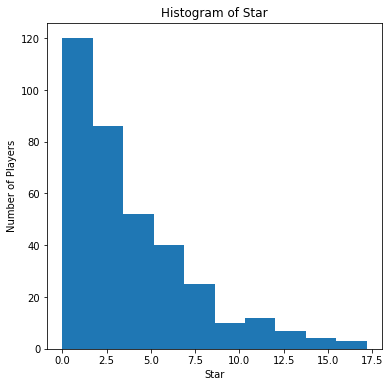

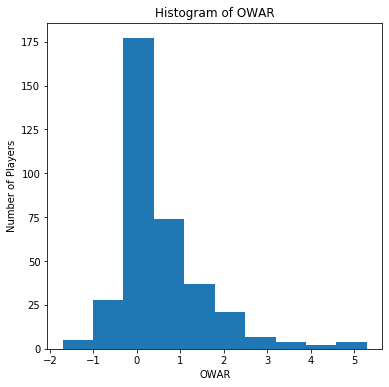

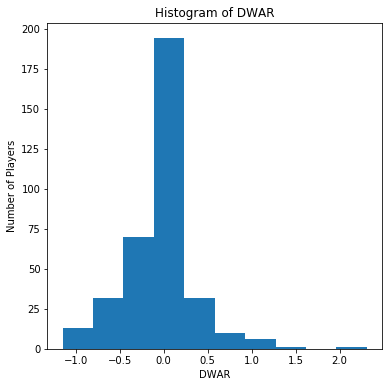

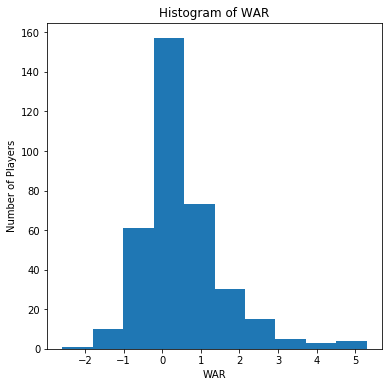

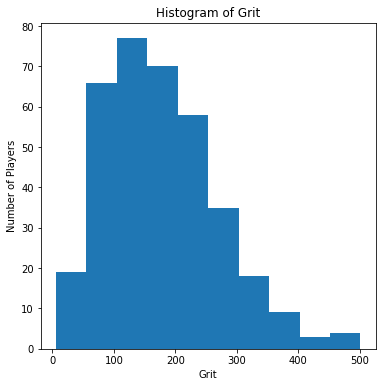

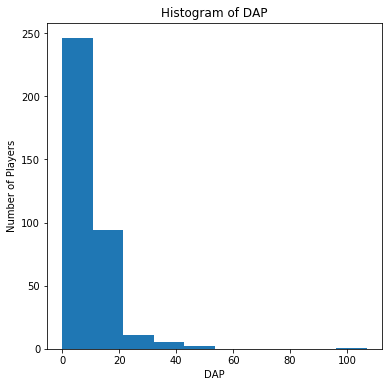

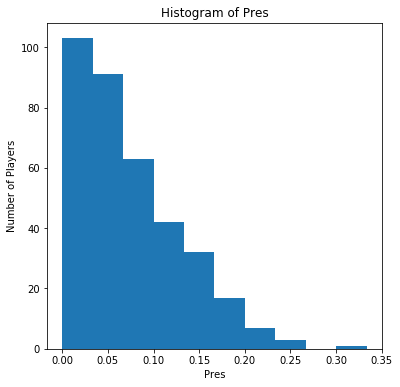

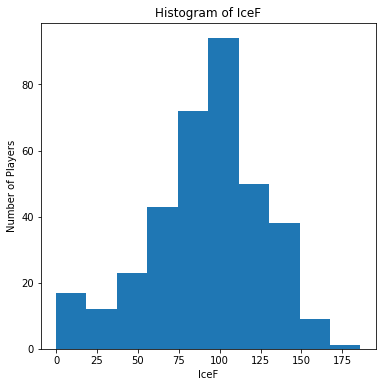

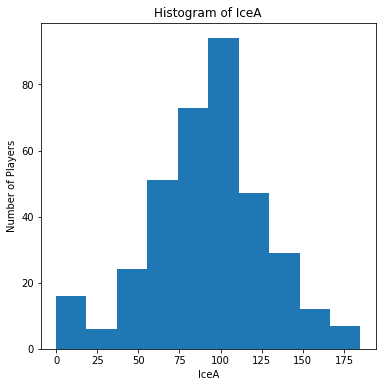

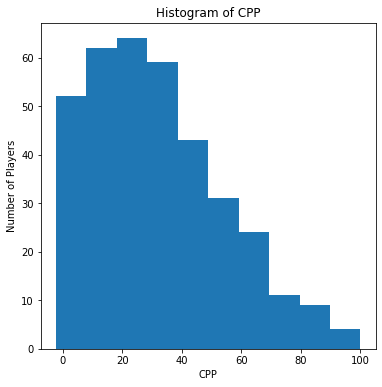

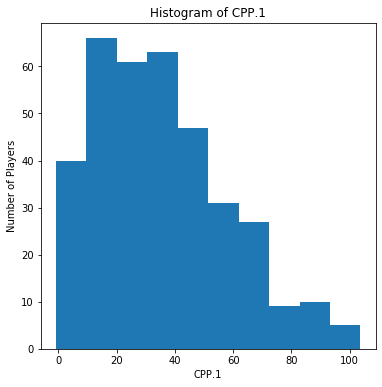

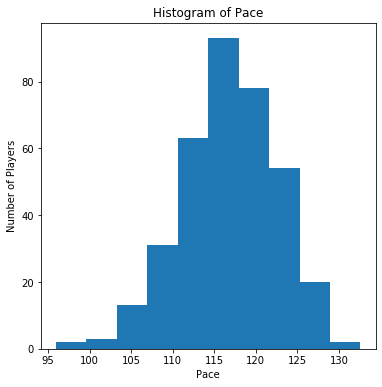

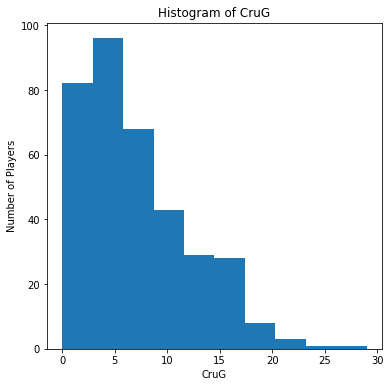

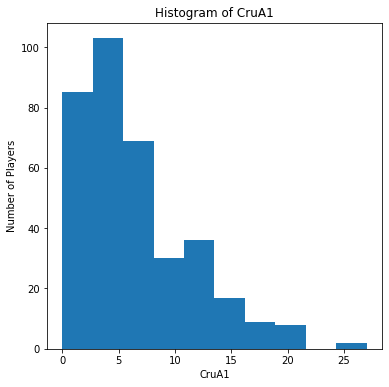

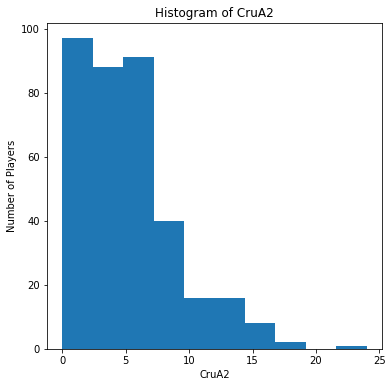

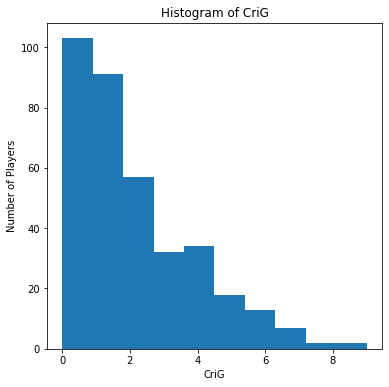

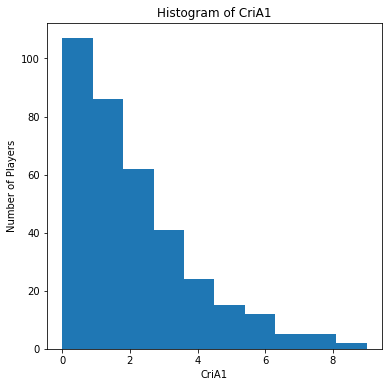

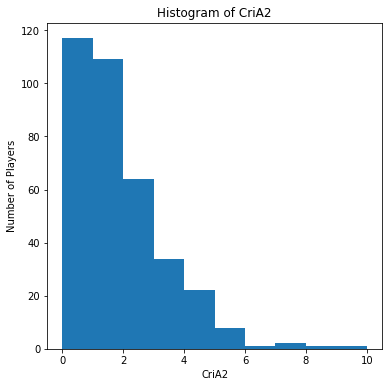

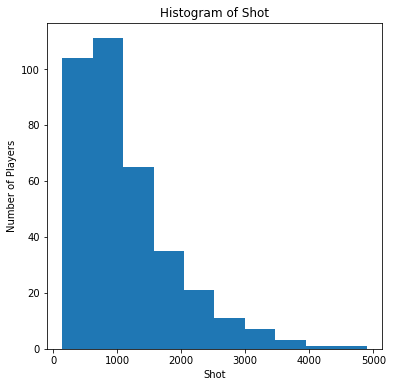

In [15]:
def plot_histogram(season18, cols, bins = 10):
    for col in cols:
        fig = plt.figure(figsize=(6,6)) # define plot area
        ax = fig.gca() # define axis    
        season18[col].plot.hist(ax = ax, bins = bins) # Use the plot.hist method on subset of the data frame
        ax.set_title('Histogram of ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel('Number of Players')# Set text for y axis
        plt.show()
        
num_cols = list(modelSeason18X.columns)
plot_histogram(modelSeason18X, num_cols)

In [16]:
from sklearn import preprocessing

x = modelSeason18X.values
normalized = preprocessing.normalize(x)
modelSeason18X = pd.DataFrame(normalized)

In [17]:
#Backward Elimination
cols = list(modelSeason18X.columns)
pmax = 1
y=modelSeason18['Cap Hit']
count=0
while (len(cols)>0):
    if(count%100==0):
        print(count)
    count=count+1
    p= []
    X_1 = modelSeason18X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(list(y),X_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)  
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

0


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


100
[1, 4, 7, 8, 11, 12, 15, 19, 33, 36, 38, 39, 43, 44, 48, 88, 107, 109, 111, 113, 114, 117, 118, 126, 129, 131, 136, 138, 144]


In [18]:
season18.columns[selected_features_BE]

Index(['City', 'Nat', 'DftYr', 'DftRd', 'Debut', 'Age', 'CorsicaID',
       'Position', 'Shifts', 'TOI%', 'iCF', 'iFF', 'iRush', 'iReb', 'Pass',
       'G.Snap', 'iPenDf', 'Min', 'Match', 'Game', 'CF', 'FA', 'SF', 'PDO',
       'HDCF', 'HDGF', 'DPS', 'GS', 'SOS'],
      dtype='object')

In [19]:
len(selected_features_BE)

29

In [20]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [21]:
X_train, X_test, y_train, y_test = train_test_split(modelSeason18X,y, test_size = 0.2, random_state = 0)

In [22]:
X2_train=X_train[[5, 8, 14, 15, 20, 21, 22, 27, 38, 39, 40, 42, 43, 51, 57, 85, 89, 90, 91, 94, 96, 104, 105, 107, 110, 118, 133, 136, 143]]
y2_train=y_train.copy()
X2_test=X_test[[5, 8, 14, 15, 20, 21, 22, 27, 38, 39, 40, 42, 43, 51, 57, 85, 89, 90, 91, 94, 96, 104, 105, 107, 110, 118, 133, 136, 143]]
y2_test=y_test.copy()

In [23]:
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_test,y_test))
coef = pd.Series(reg.coef_, index = X_test.columns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90793410953.8125, tolerance: 77817583161.92885
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103248497004.9375, tolerance: 77817583161.92885
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

Best alpha using built-in LassoCV: 26.439667
Best score using built-in LassoCV: 0.551511


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74270631347.1875, tolerance: 72603598501.76291
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78405047985.875, tolerance: 72603598501.76291
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76529430756.25, tolerance: 72603598501.76291
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to 

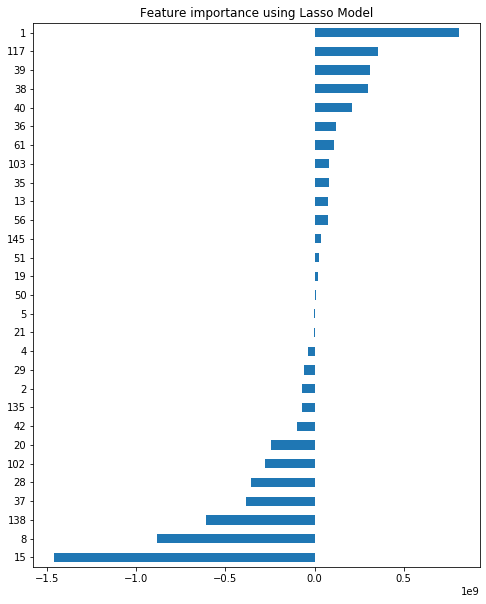

In [24]:
imp_coef = coef.sort_values()
imp_coef=imp_coef[imp_coef!=0]
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

In [25]:
reg.predict(X_test)

array([4512638.05281031, 4919893.11229834, 4510169.67359718,
       6306611.69915993, 3501050.04591065, 5800545.39125577,
       3146380.87202951, 2895934.62121886, 4923591.31542176,
       7754624.21916608, 5207841.88020263, 5349122.17360903,
       3359315.5061517 , 5089426.37349423, 4786025.34902493,
       2707250.68774843, 2873504.93170844, 3511837.48082558,
       5356019.00649276, 6037282.24862978, 4359919.1271205 ,
       3828843.20275214, 3320233.66225285, 5638042.31364091,
       3961436.77731932, 5730049.4513726 , 4194533.95884511,
       6092832.28182852, 6132560.7515583 , 4405040.98040432,
       4322012.10368901, 4112478.50222774, 3073195.15003265,
       5409733.30032085, 3296809.00638488, 5700388.12941674,
       5332654.9578235 , 3162933.8778128 , 3848759.2911745 ,
       3661308.00623304, 4639132.73421686, 2437660.48007952,
       4314211.40842647, 3832571.41983321, 4415816.85947708,
       7414145.47070482, 2795250.88102593, 3728150.73302618,
       2643862.02359231,

(array([ 1.,  2.,  1.,  5.,  7., 17., 14., 15.,  6.,  4.]),
 array([-63612.59566252, -52988.09448676, -42363.593311  , -31739.09213524,
        -21114.59095949, -10490.08978373,    134.41139203,  10758.91256779,
         21383.41374355,  32007.91491931,  42632.41609507]),
 <a list of 10 Patch objects>)

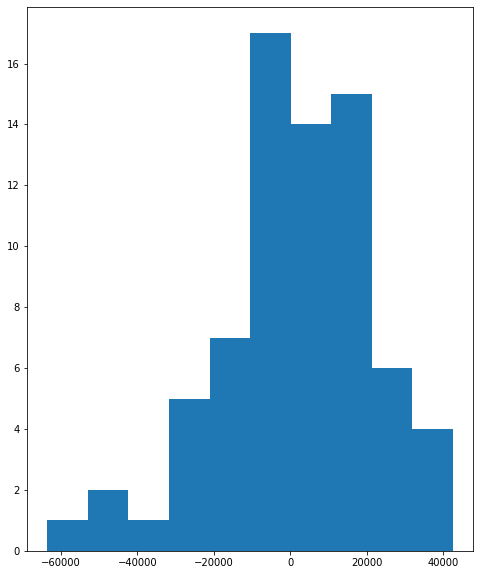

In [26]:
plt.hist((reg.predict(X_test)-y_test)/len(y_test))

(array([22., 15., 13., 11.,  3.,  2.,  4.,  1.,  0.,  1.]),
 array([  434.07466891,  6751.92676827, 13069.77886763, 19387.63096699,
        25705.48306635, 32023.33516572, 38341.18726508, 44659.03936444,
        50976.8914638 , 57294.74356316, 63612.59566252]),
 <a list of 10 Patch objects>)

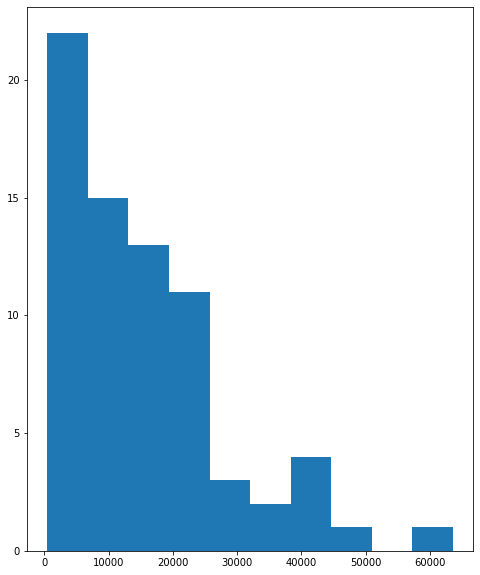

In [27]:
plt.hist((abs(reg.predict(X_test)-y_test))/len(y_test))

In [28]:
diff=reg.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-2826495.06829156
143809.8253772026
2438321.6938918037
22


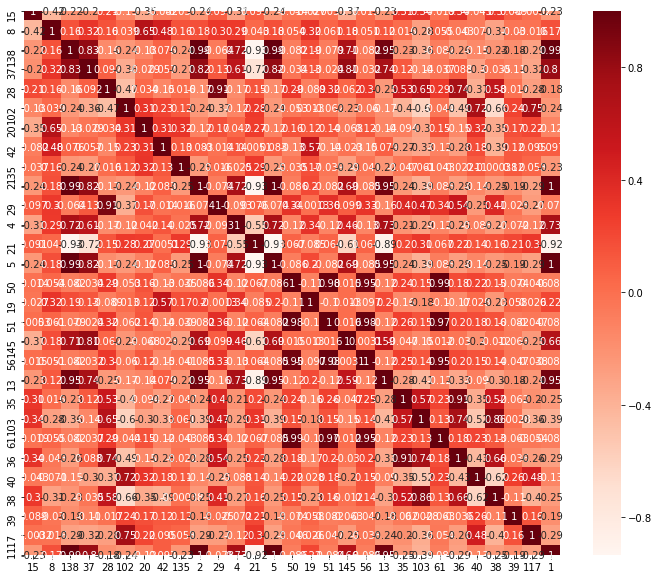

In [29]:
corr = modelSeason18X[imp_coef.index].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr.loc[corr.columns,corr.columns], annot=True, cmap=plt.cm.Reds)
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(modelSeason18X[imp_coef.index],y, test_size = 0.2, random_state = 0)

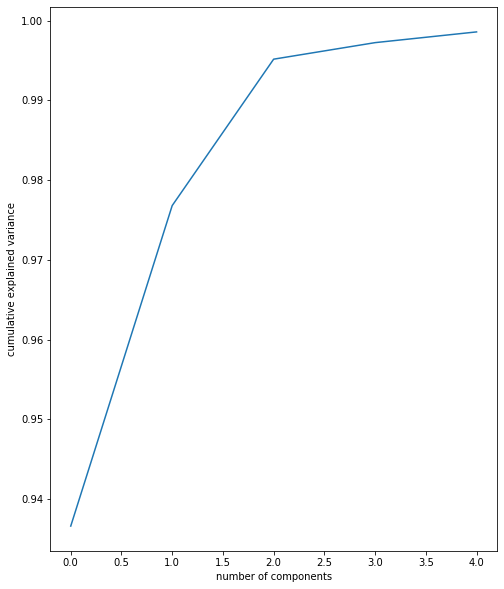

In [31]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[0:5])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [32]:
pca=PCA(2)
pca.fit(X_train)
pcatrain_x = pca.transform(X_train)
pcatest_x = pca.transform(X_test)
reg = LassoCV()
reg.fit(pcatrain_x, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [33]:
diff=reg.predict(pcatest_x)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

print(reg.score(pcatest_x, y_test))

-4616133.8917297125
213360.9818390971
2975906.7208486767
20
0.09072513343933153


In [34]:
import xgboost as xgb
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test,y_test)
params={
    'objective':"reg:squarederror",
    'eval_metric':["rmse","mae"]
}
evallist=[(dtest,'eval'),(dtrain,'train')]

In [35]:
num_round = 1000
bst=xgb.train(params,dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-rmse:3478522.00000	eval-mae:2922575.00000	train-rmse:3453349.25000	train-mae:3074492.25000
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-rmse:2593294.00000	eval-mae:2059736.87500	train-rmse:2542280.25000	train-mae:2214421.50000
[2]	eval-rmse:2085121.75000	eval-mae:1600096.50000	train-rmse:1894368.62500	train-mae:1595750.25000
[3]	eval-rmse:1801568.25000	eval-mae:1349124.50000	train-rmse:1420100.37500	train-mae:1156203.00000
[4]	eval-rmse:1645510.50000	eval-mae:1200763.00000	train-rmse:1084354.62500	train-mae:843495.25000
[5]	eval-rmse:1557844.75000	eval-mae:1139655.75000	train-rmse:846213.93750	train-mae:631822.12500
[6]	eval-rmse:1513111.87500	eval-mae:1110578.25000	train-rmse:676686.06250	train-mae:488594.21875
[7]	eval-rmse:1484409.87500	eval-mae:1105631.25000	train-rmse:534780.75000	train-mae:384778.68750
[8]	eval-rmse:1471049.12500	eval-mae:1106679.00000	train-rmse:44

[84]	eval-rmse:1493304.12500	eval-mae:1176367.50000	train-rmse:269.86459	train-mae:190.18858
[85]	eval-rmse:1493303.25000	eval-mae:1176364.87500	train-rmse:249.23230	train-mae:177.03615
[86]	eval-rmse:1493307.37500	eval-mae:1176370.37500	train-rmse:238.56212	train-mae:168.58449
[87]	eval-rmse:1493302.62500	eval-mae:1176366.12500	train-rmse:219.67073	train-mae:154.43771
[88]	eval-rmse:1493296.37500	eval-mae:1176365.62500	train-rmse:206.93898	train-mae:145.07709
[89]	eval-rmse:1493295.87500	eval-mae:1176365.87500	train-rmse:185.74184	train-mae:130.27396
[90]	eval-rmse:1493298.75000	eval-mae:1176368.87500	train-rmse:169.55931	train-mae:118.15505
[91]	eval-rmse:1493295.00000	eval-mae:1176364.87500	train-rmse:152.58385	train-mae:106.89329
[92]	eval-rmse:1493300.00000	eval-mae:1176370.25000	train-rmse:140.90018	train-mae:97.26568
[93]	eval-rmse:1493298.12500	eval-mae:1176370.25000	train-rmse:133.19481	train-mae:91.49129
[94]	eval-rmse:1493296.37500	eval-mae:1176367.75000	train-rmse:121.38079

[175]	eval-rmse:1493296.25000	eval-mae:1176370.37500	train-rmse:0.51263	train-mae:0.38458
[176]	eval-rmse:1493296.25000	eval-mae:1176370.37500	train-rmse:0.50644	train-mae:0.38023
[177]	eval-rmse:1493296.25000	eval-mae:1176370.37500	train-rmse:0.50396	train-mae:0.37848
[178]	eval-rmse:1493296.25000	eval-mae:1176370.37500	train-rmse:0.50038	train-mae:0.37848
[179]	eval-rmse:1493296.25000	eval-mae:1176370.37500	train-rmse:0.48597	train-mae:0.36847
[180]	eval-rmse:1493296.25000	eval-mae:1176370.37500	train-rmse:0.48153	train-mae:0.36280
[181]	eval-rmse:1493296.25000	eval-mae:1176370.37500	train-rmse:0.47977	train-mae:0.35889
[182]	eval-rmse:1493296.37500	eval-mae:1176370.37500	train-rmse:0.47858	train-mae:0.35845
[183]	eval-rmse:1493296.37500	eval-mae:1176370.37500	train-rmse:0.47858	train-mae:0.35845
[184]	eval-rmse:1493296.37500	eval-mae:1176370.37500	train-rmse:0.47858	train-mae:0.35845
[185]	eval-rmse:1493296.37500	eval-mae:1176370.37500	train-rmse:0.47858	train-mae:0.35845
[186]	eval

In [36]:
xgbPred=bst.predict(dtest,ntree_limit=bst.best_ntree_limit)

In [37]:
diff=xgbPred-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))


-2207852.0
376877.5
2455662.5
22


In [38]:
from sklearn.metrics import mean_squared_error
mean_squared_error(xgbPred,y_test)

2229934204895.6455

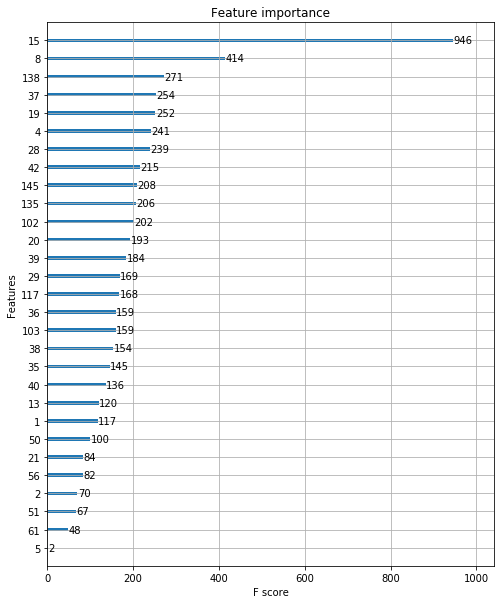

In [39]:
xgb.plot_importance(bst)

(array([ 2.,  6.,  9., 18., 19.,  3.,  7.,  5.,  1.,  2.]),
 array([-3.333631  , -2.59788945, -1.8621479 , -1.12640635, -0.3906648 ,
         0.34507675,  1.0808183 ,  1.81655985,  2.5523014 ,  3.28804295,
         4.0237845 ]),
 <a list of 10 Patch objects>)

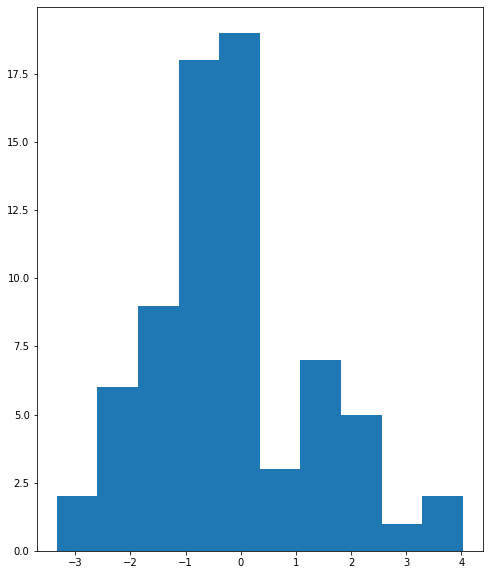

In [40]:
plt.hist((y_test.subtract(xgbPred))/1000000)

In [41]:
diff=y_test.subtract(xgbPred)
len(diff[abs(diff)<500000])

22

In [42]:
len(diff)

72

In [43]:
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])

-2455662.5
-347152.5
2207852.0


In [44]:
from sklearn.tree import DecisionTreeRegressor

dtree=DecisionTreeRegressor()
#dtree.fit(X2_train,y2_train)
dtree.fit(X_train,y_train)

#diff=dtree.predict(X2_test)-y2_test
diff=dtree.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)

(array([ 4.,  5.,  6., 14.,  6., 11., 13., 11.,  1.,  1.]),
 array([-3538462. , -2744615.8, -1950769.6, -1156923.4,  -363077.2,
          430769. ,  1224615.2,  2018461.4,  2812307.6,  3606153.8,
         4400000. ]),
 <a list of 10 Patch objects>)

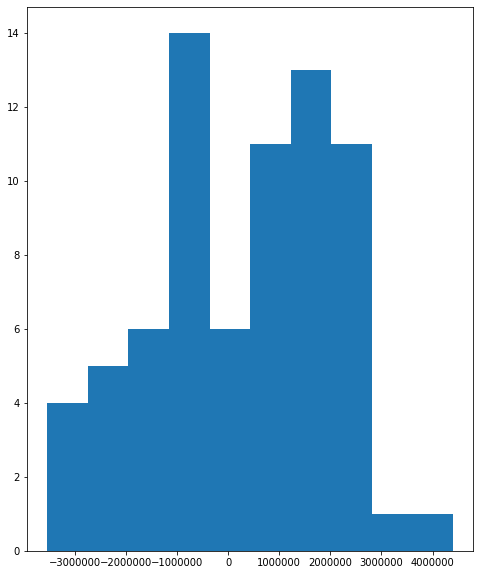

In [45]:
plt.hist(diff)

In [46]:
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-2875000.0
500000.0
2750000.0
10


In [47]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
svr.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [48]:
diff=svr.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
sum(diff)/len(y_test)

-34228.18745319301

In [49]:
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-4750000.099611714
149999.89298241213
3099999.893386814
21


In [50]:
len(diff[abs(diff)<500000])/len(diff)

0.2916666666666667

In [51]:
from sklearn.linear_model import SGDRegressor

sgd=SGDRegressor(max_iter=1000, tol=1e-3)
sgd.fit(X_train,y_train)
sgd.score(X_test,y_test)

0.0008385394143954894

In [52]:
diff=sgd.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-4682399.941516425
213361.1325456826
3163756.4964911733
20


In [53]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor()
model.fit(X_train,y_train)

diff=model.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

print(model.score(X_test,y_test))

-2309285.7
244047.59999999963
2333254.3
19
0.5311401605838177


(array([ 3.,  0.,  2.,  6.,  7., 10., 17., 14.,  8.,  5.]),
 array([-4146500.  , -3468044.44, -2789588.88, -2111133.32, -1432677.76,
         -754222.2 ,   -75766.64,   602688.92,  1281144.48,  1959600.04,
         2638055.6 ]),
 <a list of 10 Patch objects>)

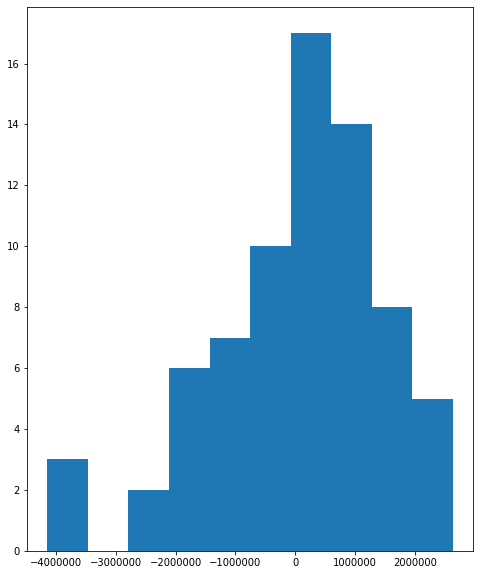

In [54]:
plt.hist(diff)

In [55]:
np.std(diff)

1477958.6387133168

In [56]:
model = BaggingRegressor()
model.fit(X2_train,y2_train)

diff=model.predict(X2_test)-y2_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

print(model.score(X2_test,y2_test))

-3124652.4000000004
220000.0
2342500.0
24
0.45326853694826214


(array([ 1.,  2.,  1.,  5.,  7.,  8., 18., 12., 10.,  8.]),
 array([-4933333.3, -4175000. , -3416666.7, -2658333.4, -1900000.1,
        -1141666.8,  -383333.5,   374999.8,  1133333.1,  1891666.4,
         2649999.7]),
 <a list of 10 Patch objects>)

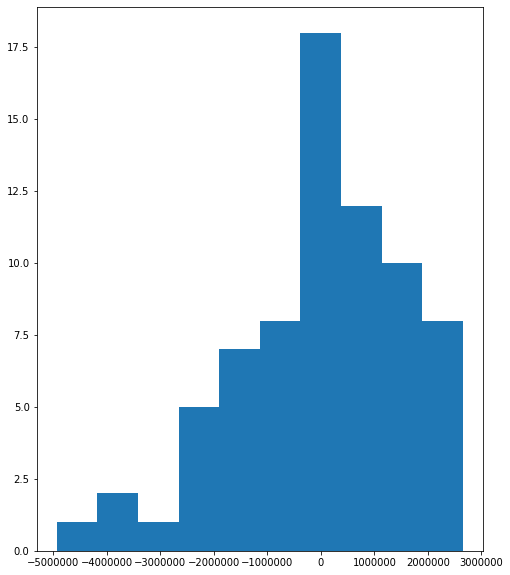

In [57]:
plt.hist(diff)

In [58]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=3000000).fit(X_train, y_train)
regr.predict(X_test)
regr.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.4362971242867932

In [59]:
diff=regr.predict(X_test)-y_test
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-3090904.3061060533
161110.03853707807
2310896.306469757
23
